In [51]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm
import scipy.integrate as integrate

import emcee
import time
import corner
import herschelhelp

In [52]:
def integrate_function(function,function_params,low_lim,high_lim,dx):
    #integrate a function using the trapezium rule
    total = 0
    x_steps = np.arange(low_lim,high_lim+dx,dx)
    for n in range(len(x_steps)-1):
        y1 = function(x_steps[n],function_params)
        y2 = function(x_steps[n+1],function_params)
        y_avg = (y1+y2)/2
        area = y_avg*dx
        total = total + area
    return(total)

In [53]:
def gaussian(x,params):
    mean,sig,amp = params
    return(amp/(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mean)**2/(2*sig**2))))

In [94]:
def gaussian_pdf(x,params):
    mean,sig = params
    return(1/(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mean)**2/(2*sig**2))))

In [124]:
def gaus_pdf_cutoff(x,params):
    mean,sig,cutoff = params
    tot = 1/(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mean)**2/(2*sig**2)))
    selection = np.where(x<cutoff,1,0)
    return(tot*selection)

In [54]:
def double_gaus(x,params):
    mean1,sig1,amp1,mean2,sig2,amp2 = params
    params1 = [mean1,sig1,amp1]
    gaus1 = gaussian(x,params1)
    params2 = [mean2,sig2,amp2]
    gaus2 = gaussian(x,params2)
    return(gaus1+gaus2)

In [55]:
def double_gaus_with_cutoff(x,params):
    mean1,sig1,amp1,mean2,sig2,amp2,cutoff = params
    params1 = [mean1,sig1,amp1]
    gaus1 = gaussian(x,params1)
    params2 = [mean2,sig2,amp2]
    gaus2 = gaussian(x,params2)
    tot = gaus1+gaus2
    mask = x<cutoff
    tot[mask] = 0
    selection = np.where(x<cutoff,1,0)
    return(tot)

In [56]:
def double_gaus_with_cdf(x,params):
    mean1,sig1,amp1,mean2,sig2,amp2,cdf_mean,cdf_sig = params
    params1 = [mean1,sig1,amp1]
    gaus1 = gaussian(x,params1)
    params2 = [mean2,sig2,amp2]
    gaus2 = gaussian(x,params2)
    tot = gaus1+gaus2
    cdf = norm.cdf(x,cdf_mean,cdf_sig)
    tot = tot*cdf
    return(tot)

In [57]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [58]:
def generate_q_values(mean,sig,n,q_min):
    q = np.random.normal(mean,sig,n)
    mask = q>q_min
    return(q[mask])

In [59]:
def agn_luminosity_function(L):
    #returns N for the luminsity function from Heckman and Best 2014 page 615
    A = 10**(-5.33)
    P0 = 10**24.95
    alpha = 0.42
    beta = 1.66
    
    N = A/((L/P0)**alpha + (L/P0)**beta)
    return(N)

In [60]:
def sf_luminosity_function(L):
    #returns the luminosity function from Mauch and Sadler 2007
    C = 10**(-2.83)
    P0 = 10**(21.18)
    sig = 0.6
    alpha = 1.02
    
    N = C*(L/P0)**(1-alpha) * np.exp(-0.5*((np.log10(1+L/P0)/sig)**2))
    return(N)

In [61]:
def mcmc_sample_from_pdf(func,N,xmin,xmax,ymin,ymax):
    x = []
    for n in range(N):
        x.append(random.random())
    x = np.array(x)
    x = x+xmin + (x*(xmax-xmin))

    y = []
    for n in range(N):
        y.append(random.random())
    y = np.array(y)
    y = y+ymin + (y*(ymax-ymin))
    
    test = func(10**x)
    mask = y<np.log10(test)
    
    return(x[mask])

In [62]:
def get_fir_lum(L,q,sig):
    #given the radio luminosity of a source (in W) it will return a FIR luminosity based on a FIRC 
    #from a given q value and scatter sig
    noise = np.random.normal(0,sig,len(L))
    q = q + noise
    fir = q + L + np.log10(3.75E12)
    return(fir)

In [63]:
def model(x,theta):
    
    #ratio is the ratio of the amplitudes of the two gaussians where ratio=amp1/amp2
    mean1,sig1,mean2,sig2,ratio = theta
    A = sig1*np.sqrt(2)
    B = sig2*np.sqrt(2)
    amp1 = ratio/(ratio + 1)
    amp2 = 1/(ratio + 1)
    
    params1 = [mean1,sig1,amp1]
    gaus1 = gaussian(x,params1)
    params2 = [mean2,sig2,amp2]
    gaus2 = gaussian(x,params2)
    return(gaus1 + gaus2)

In [64]:
def model_with_cutoff(x,theta):
    
    mean1,sig1,mean2,sig2,ratio,cutoff = theta
    A = sig1*np.sqrt(2)
    B = sig2*np.sqrt(2)
    amp1 = ratio/(ratio*A + B)
    amp2 = 1/(ratio*A + B)
    
    selection = np.where(x<cutoff,1,0)
    params1 = [mean1,sig1,amp1]
    gaus1 = gaussian(x,params1)
    params2 = [mean2,sig2,amp2]
    gaus2 = gaussian(x,params2)
    tot = gaus1 + gaus2
    return(tot*selection)

In [65]:
def selection_function_step(x,params):
    xcut = params[0]
    if x<xcut:
        return(1)
    if x>=xcut:
        return(0)
    

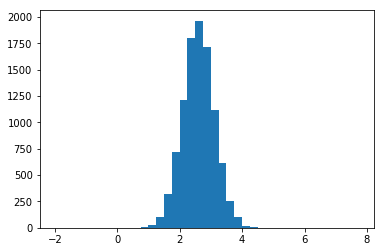

In [168]:
q_sf_mean = 2.6
q_sf_sig = 0.5
n_sf = 10000
q_sf = np.random.normal(q_sf_mean,q_sf_sig,n_sf)
q_min = 0.0

bins=np.arange(-2,8,0.25)
plt.hist(q_sf,bins=bins)
plt.show()

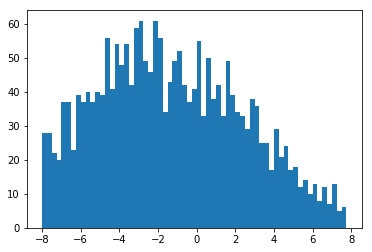

In [145]:
q_agn_mean = -2.0
q_agn_sig = 5.0
n_agn = 2500
q_agn = np.random.normal(q_agn_mean,q_agn_sig,n_agn)

bins=np.arange(-8,8,0.25)
plt.hist(q_agn,bins=bins)
plt.show()

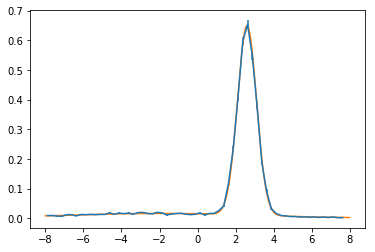

In [146]:
combined_q = np.concatenate((q_sf,q_agn))
bins=np.arange(-8,8,0.25)
x = get_center(bins)
y,_ = np.histogram(combined_q,bins=bins)
y_err = np.sqrt(y)/(n_sf+n_agn) * 4
#y,_ = np.histogram(combined_q,bins=bins,density=True)
#plt.scatter(x,y/12500*0.25)
#y_err = np.sqrt(y)
plt.errorbar(x,y/(n_sf+n_agn) * 4,y_err)
#plt.hist(combined_q,bins=bins)

x = np.arange(-8,8,0.01)
y = model(x,[q_sf_mean,q_sf_sig,q_agn_mean,q_agn_sig,n_sf/n_agn])
plt.plot(x,y)
plt.show()

In [147]:
y_err

array([ 0.00169328,  0.00169328,  0.00150093,  0.00143108,  0.00194648,
        0.00194648,  0.00153467,  0.0019984 ,  0.00194648,  0.00202386,
        0.00194648,  0.00202386,  0.0019984 ,  0.00239466,  0.002049  ,
        0.00235151,  0.00221703,  0.00235151,  0.00207384,  0.00245797,
        0.00249928,  0.00224   ,  0.00217035,  0.00249928,  0.00239466,
        0.0018659 ,  0.00209838,  0.00224   ,  0.00230755,  0.00207384,
        0.00194648,  0.002049  ,  0.00237318,  0.00183826,  0.00226274,
        0.00228526,  0.00288   ,  0.0036345 ,  0.006147  ,  0.00868138,
        0.01141732,  0.01381199,  0.01445323,  0.01323656,  0.01099236,
        0.00776618,  0.00541169,  0.00321596,  0.00226274,  0.00172325,
        0.00156767,  0.00131939,  0.00135765,  0.00110851,  0.00119733,
        0.00101193,  0.00115378,  0.0009051 ,  0.00110851,  0.00084664,
        0.00115378,  0.00071554,  0.00078384])

In [70]:
L_FIR_min = 2
L_rad_min = L_FIR_min*2
L_rad_max = L_FIR_min*3
q_min = L_FIR_min - L_rad_min
print(q_min)

-2


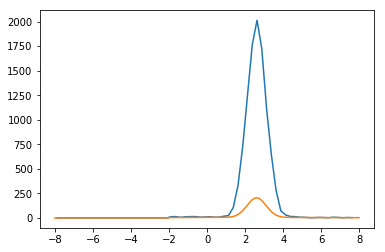

In [71]:
mask = combined_q>q_min
bins=np.arange(-8,8,0.25)
x = get_center(bins)
y,_ = np.histogram(combined_q[mask],bins=bins) 
#plt.hist(combined_q[mask],bins=bins)
plt.plot(x,y)
x = np.arange(-8,8,0.01)
params = [2.6,0.5,250,2.0,5.0,250/4,-2]
fit = double_gaus_with_cutoff(x,params)
plt.plot(x,fit)

plt.show()

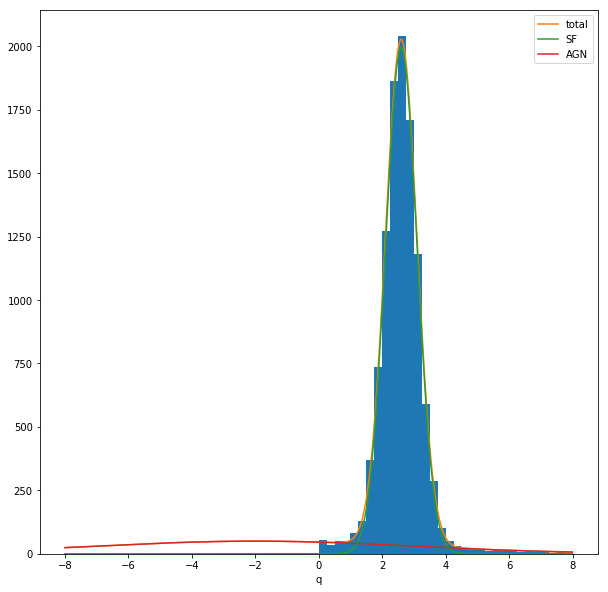

In [193]:
mask = combined_q>q_min

fig = plt.figure(figsize=[10,10])
bins=np.arange(-8,8,0.25)
plt.hist(combined_q[mask],bins=bins)
x = np.arange(-8,8,0.01)
params = [q_sf_mean,q_sf_sig,n_sf/4,q_agn_mean,q_agn_sig,n_agn/4,q_min]
fit = double_gaus_with_cutoff(x,params)
#plt.plot(x,fit)

params = [q_sf_mean,q_sf_sig,q_agn_mean,q_agn_sig,n_sf/n_agn]
fit = model(x,params) * (n_sf+n_agn)/4
plt.plot(x,fit,label='total')

params = [q_sf_mean,q_sf_sig,n_sf/4]
fit = gaussian(x,params) 
plt.plot(x,fit,label='SF')

params = [q_agn_mean,q_agn_sig,n_agn/4]
fit = gaussian(x,params) 
plt.plot(x,fit,label='AGN')

plt.xlabel('q')
plt.legend()
plt.show()

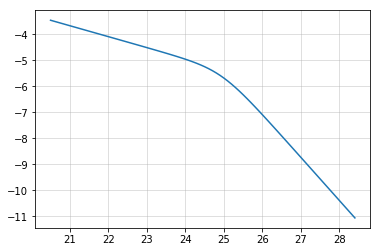

In [73]:
x = np.arange(20.5,28.5,0.1)
y = agn_luminosity_function(10**x)
plt.plot(x,np.log10(y))
plt.grid(alpha=0.5)
plt.show()

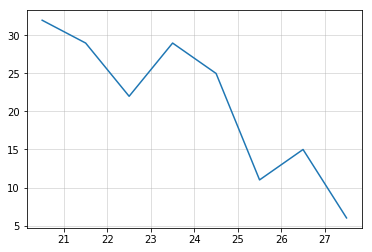

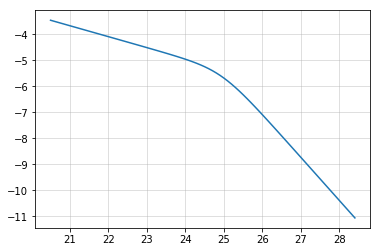

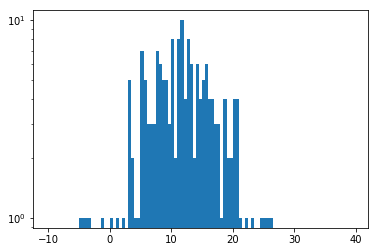

In [74]:
agn_lum = mcmc_sample_from_pdf(agn_luminosity_function,300,20,29,np.log10(agn_luminosity_function(1E20)),np.log10(agn_luminosity_function(1E29)))

bins = np.arange(20,29,1)
x = get_center(bins)
y,_ = np.histogram(agn_lum,bins=bins)
plt.plot(x,y)
plt.grid(alpha=0.5)
plt.show()
x = np.arange(20.5,28.5,0.1)
y = agn_luminosity_function(10**x)
plt.plot(x,np.log10(y))
plt.grid(alpha=0.5)
plt.show()

agn_lum_fir = get_fir_lum(agn_lum,2,5)
y = agn_lum_fir - np.log10(3E26)
bins=np.arange(-10,40,0.5)
plt.hist(y,bins=bins,log=True)
plt.show()

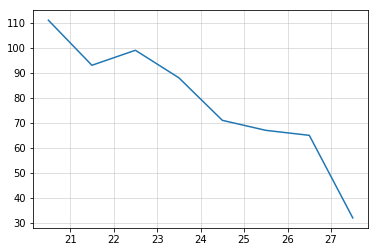

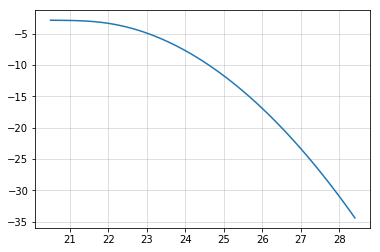

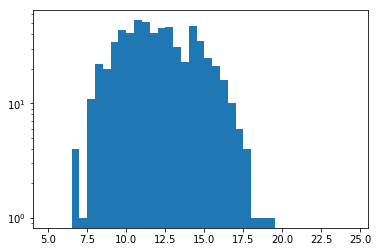

In [75]:
sf_lum = mcmc_sample_from_pdf(sf_luminosity_function,1000,20,29,np.log10(sf_luminosity_function(1E20)),np.log10(sf_luminosity_function(1E29)))

bins = np.arange(20,29,1)
x = get_center(bins)
y,_ = np.histogram(sf_lum,bins=bins)
plt.plot(x,y)
plt.grid(alpha=0.5)
plt.show()
x = np.arange(20.5,28.5,0.1)
y = sf_luminosity_function(10**x)
plt.plot(x,np.log10(y))
plt.grid(alpha=0.5)
plt.show()

sf_lum_fir = get_fir_lum(sf_lum,2.6,1)
y = sf_lum_fir - np.log10(3E26)
bins=np.arange(5,25,0.5)
plt.hist(y,bins=bins,log=True)
plt.show()

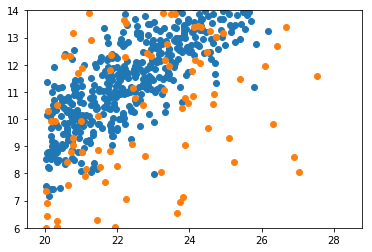

In [76]:
x = sf_lum
y = sf_lum_fir - 26
plt.scatter(x,y)

x = agn_lum
y = agn_lum_fir - 26
plt.scatter(x,y)

plt.ylim(6,14)
plt.show()

In [178]:
def lnprior(theta):

    P = np.zeros(len(theta))

    for i,p in enumerate(params):
        if ( PRIORS[p][0]< theta[i] < PRIORS[p][1] ): 
            P[i] = 1.0
        else:
            P[i] = 0.0
            
    # return the log of the probability, in this case either log of 1 or 0.
    if np.product(P) == 0.0: 
        return(-np.inf)
        #return(0.0)
    else: 
        return(0.0)
        #return(1.0)
    
def lnlike(theta,x,y,y_err):
    #return(-0.5*sum( ( y-model( x, theta  ) )**2))
    #plt.scatter(x,y)
    #plt.plot(x,model(x,theta))
    #plt.show()
    
    #NEED TO ACCOUNT FOR ERRORS ON BINS WITH NO DATA IN THEM WHICH ARE GIVEN AN ERROR OF 0
    lnlike = -0.5*np.sum(np.log((y - model(x,theta))**2/y_err))
    #print(lnlike)
    #lnlike = -0.5*np.prod(((y - model(x,theta))**2))
    #mask = np.isfinite(lnlike)
    #lnlike = lnlike[mask]
    return(lnlike)
    
def lnmissing(theta,y_tot,n_missing,selection,theta_sel):
    
    '''dx = 0.01
    x = np.arange(-20,20,dx)
    area = 0
    for n in range(len(x)-1):
        y1 = model(x[n],theta) * selection(x[n],theta_sel)
        y2 = model(x[n+1],theta) * selection(x[n+1],theta_sel)
        y_avg = (y1+y2)/2
        area = y_avg*dx + area
    lnmissing = area*n_missing'''

    theta = np.insert(theta,len(theta),theta_sel[0])
    lnmissing = -0.5*np.log((integrate.quad(model_with_cutoff,-20,20,args=theta)[0] - n_missing/(y_tot+n_missing))**2)
    #lnmissing = -0.5*((integrate.quad(model_with_cutoff,-20,20,args=theta)[0] - n_missing/(y_tot+n_missing))**2)
    return(lnmissing)

def lnprob(theta,x,y,y_err,n_missing,selection,theta_sel):
    
    lp = lnprior(theta)
    #print(lp)
    ll = lnlike(theta,x,y,y_err)
    #print(ll)
    lm = lnmissing(theta,np.sum(y),n_missing,selection,theta_sel)
    #print(lm)

    if not np.isfinite(lp) or not np.isfinite(ll) or not np.isfinite(lm):
        return -np.inf
    else:
        return lp + ll + lm

In [132]:
def lnprior_gaus(theta):

    P = np.zeros(len(theta))

    for i,p in enumerate(params_gaus):
        if ( PRIORS_gaus[p][0]< theta[i] < PRIORS[p][1] ): 
            P[i] = 1.0
        else:
            P[i] = 0.0
            
    # return the log of the probability, in this case either log of 1 or 0.
    if np.product(P) == 0.0: 
        return(-np.inf)
        #return(0.0)
    else: 
        return(0.0)
        #return(1.0)
    
def lnlike_gaus(theta,x,y,y_err):
    #return(-0.5*sum( ( y-model( x, theta  ) )**2))
    #plt.scatter(x,y)
    #plt.plot(x,model(x,theta))
    #plt.show()
    
    #NEED TO ACCOUNT FOR ERRORS ON BINS WITH NO DATA IN THEM WHICH ARE GIVEN AN ERROR OF 0
    lnlike = -0.5*np.sum(np.log((y - gaussian_pdf(x,theta))**2/y_err))
    #print(lnlike)
    #lnlike = -0.5*np.prod(((y - model(x,theta))**2))
    #mask = np.isfinite(lnlike)
    #lnlike = lnlike[mask]
    return(lnlike)
    
def lnmissing_gaus(theta,y_tot,n_missing,selection,theta_sel):
    
    '''dx = 0.01
    x = np.arange(-20,20,dx)
    area = 0
    for n in range(len(x)-1):
        y1 = model(x[n],theta) * selection(x[n],theta_sel)
        y2 = model(x[n+1],theta) * selection(x[n+1],theta_sel)
        y_avg = (y1+y2)/2
        area = y_avg*dx + area
    lnmissing = area*n_missing'''

    theta = np.insert(theta,len(theta),theta_sel[0])
    lnmissing = -0.5*np.log((integrate.quad(gaus_pdf_cutoff,-20,20,args=theta)[0] - n_missing/(y_tot+n_missing))**2)
    #lnmissing = -0.5*((integrate.quad(model_with_cutoff,-20,20,args=theta)[0] - n_missing/(y_tot+n_missing))**2)
    return(lnmissing)

def lnprob_gaus(theta,x,y,y_err,n_missing,selection,theta_sel):
    
    lp = lnprior_gaus(theta)
    #print(lp)
    ll = lnlike_gaus(theta,x,y,y_err)
    #print(ll)
    lm = lnmissing_gaus(theta,np.sum(y),n_missing,selection,theta_sel)
    #print(lm)

    if not np.isfinite(lp) or not np.isfinite(ll) or not np.isfinite(lm):
        return -np.inf
    else:
        return lp + ll + lm

In [133]:
theta = [2.6,0.5]
PRIORS_gaus = {     'mean_sf'   :  [ 0   ,   4 ] ,
               'sig_sf'   :  [ 0   ,   3 ]}
params_gaus = ['mean_sf','sig_sf']
nwalkers = 30  # number of individual chains to make
ndim     = len(params_gaus) # number of dimensions
preburns = 200  # length of "burn-in" period to be discarded
burns    = 200 # number of iterations to be used after initial burn-in.

In [171]:
pos = np.zeros((nwalkers,ndim))  

for j,p in enumerate(params_gaus):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = np.random.rand(nwalkers)*(PRIORS_gaus[params[j]][1]-PRIORS_gaus[params[j]][0]) + PRIORS_gaus[params[j]][0]

x = np.arange(-4,8,0.25)
x_obs = get_center(x)
y_obs,_ = np.histogram(combined_q,bins=x)
y_obs = y_obs/(n_sf+n_agn)*4
y_err = np.sqrt(y_obs*(n_sf+n_agn)/4)/(n_sf+n_agn)*4
plt.scatter(x_obs,y_obs,c='black')
plt.show()
#print(np.sum(y_obs))
mask = x_obs>q_min
sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob_gaus, args=[x_obs[mask],y_obs[mask],y_err[mask],np.sum(y_obs[~mask]),selection_function_step,[-2]] )

time0 = time.time()
print('MCMC start ')

pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

KeyError: 2.6

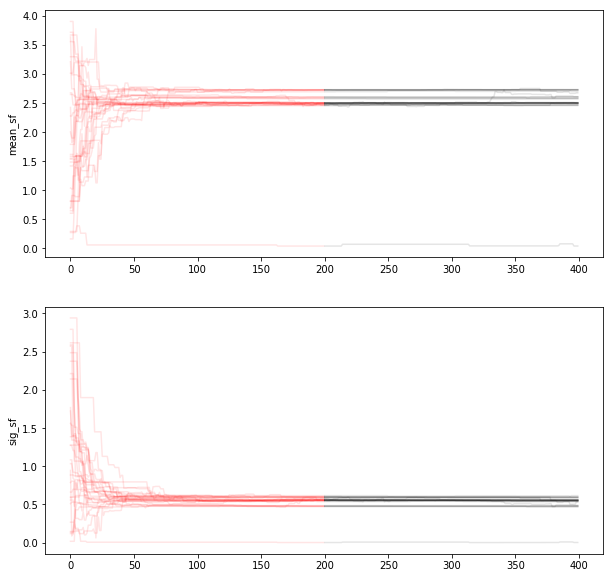

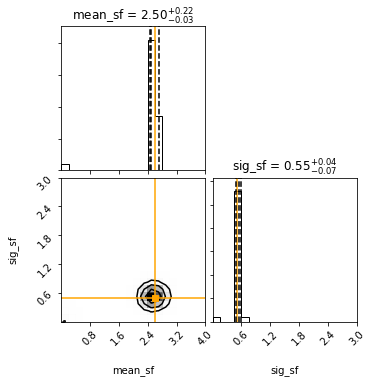

In [135]:
theta_true = np.array([2.6,0.5])

fig2,axarr = plt.subplots( ndim,1 ,figsize=(10,10))

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot( np.arange(0, preburns ,1) , sampler.chain[i,:preburns,j] , alpha=0.1, color='r' )
        axarr[j].plot( np.arange(preburns, burns+preburns ,1) , sampler.chain[i,preburns:,j] , alpha=0.1, color='k' )

    axarr[j].set_ylabel( params[j] )

import corner
fig = corner.corner(samples, labels= params_gaus , truths = theta_gaus, truth_color='orange', show_titles=True,\
        quantiles=[.16,.50,.84], smooth=1.0, \
        range = [(PRIORS_gaus[i][0],PRIORS_gaus[i][1]) for i in params_gaus])

theta = [2.6,0.5,2.0,5.0,5]
time0 = time.time()
print('MCMC start ')

print(lnmissing(theta,1,selection_function_step,[-2]))

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)


theta = [2.6,0.5,2.0,5.0,5,-2]
time0 = time.time()
print('MCMC start ')

print(integrate.quad(model_with_cutoff,-20,20,theta))

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)

In [173]:
params = ['mean_sf','sig_sf','mean_agn','sig_agn','sf/agn']
nwalkers = 30  # number of individual chains to make
ndim     = len(params) # number of dimensions
preburns = 200  # length of "burn-in" period to be discarded
burns    = 200 # number of iterations to be used after initial burn-in.

In [174]:
PRIORS = {     'mean_sf'   :  [ 1   ,   4 ] ,
               'sig_sf'   :  [ 0   ,   2 ] ,
               'mean_agn'    :  [  -5   ,    5 ] ,
               'sig_agn'    :  [  0   ,    10 ] ,
               'sf/agn'    :  [  0   ,    30 ]  }

[2.6, 0.5, 0.0, 5.0, 20.0]
140.105348942
144.732775931
[  3.26834399   3.31366877   3.10245988   3.73534374   3.42140345
   3.18420667   3.79071487   4.5149998    3.85453425   3.74063388
   3.11126441   3.95830017   2.29403636   3.76747756   2.26974806
   2.34469496   2.40872289   1.96498849   3.26647425   5.98964952
   1.96234049   1.84137945   1.96598608   2.55518535   3.43746948
   3.10043695   2.79414111   4.72969905   6.72620144   2.829656
   2.91671054  11.31326399   4.62590072   2.70550458   3.37414618
   4.22126713   2.97579972   4.73024438   3.99835032]
140.105348942
262.631475233
267.258902222
[  6.56352474   6.60884951   6.5909381    7.05053516   6.7165842
   6.46086043   7.20727257   7.90211174   7.16972568   7.15719158
   6.56120496   7.18641492   5.43594099   6.54040556   4.75639298
   4.63216792   4.56201659   4.03243009   5.30092282   8.062967
   4.14438204   4.15893936   4.4928155    5.41898858   6.52358822
   6.35984249   6.08932186   8.1796396   10.21467966   6.59278

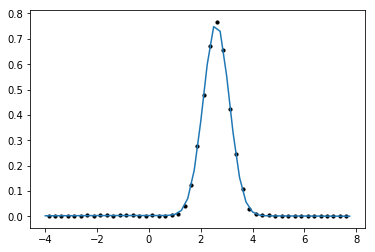

In [86]:
theta = [2.6,0.5,0.0,5.0,20.0]
#theta = median_params
print(theta)
x = np.arange(-4,8,0.25)
x_obs = get_center(x)
y_obs,_ = np.histogram(combined_q,bins=x)
y_err = np.sqrt(y_obs)/(n_sf+n_agn)*4
y_obs = y_obs/(n_sf+n_agn)*4
#print(np.sum(y_obs))
mask = x_obs>q_min

plt.plot(x,model(x,theta))
plt.scatter(x_obs,y_obs,s=10,c='black')
print(lnprob(theta,x_obs[mask],y_obs[mask],y_err[mask],np.sum(y_obs[~mask]),'a',[-2]))
print(-0.5*np.log((y_obs[mask] - model(x_obs[mask],theta))**2/y_err[mask]))
print(-0.5*np.sum(np.log(((y_obs[mask] - model(x_obs[mask],theta))**2/y_err[mask]))))

print(lnprob(theta,x_obs[mask],y_obs[mask],np.ones(np.sum(mask)),np.sum(y_obs[~mask]),'a',[-2]))
print(-0.5*np.log((y_obs[mask] - model(x_obs[mask],theta))**2))
print(-0.5*np.sum(np.log(((y_obs[mask] - model(x_obs[mask],theta))**2))))

-525.26295046660903

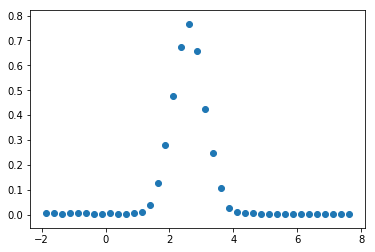

In [81]:
theta = [2.6,0.5,0.0,5.0,20.0]
n = 10
y = y_obs[mask]
x = x_obs[mask]
plt.scatter(x,y)
np.sum(np.log((y - model(x,theta))**2))

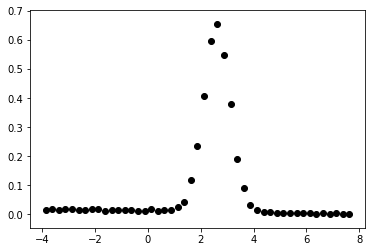

3.69888
MCMC start 
MCMC end, Time taken:  107.83837389945984


In [179]:
pos = np.zeros((nwalkers,ndim))  

for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = np.random.rand(nwalkers)*(PRIORS[params[j]][1]-PRIORS[params[j]][0]) + PRIORS[params[j]][0]

x = np.arange(-4,8,0.25)
x_obs = get_center(x)
y_obs,_ = np.histogram(combined_q,bins=x)
y_obs = y_obs/(n_sf+n_agn)*4
y_err = np.sqrt(y_obs*(n_sf+n_agn)/4)/(n_sf+n_agn)*4
plt.scatter(x_obs,y_obs,c='black')
plt.show()
print(np.sum(y_obs))
mask = x_obs>q_min
sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[x_obs[mask],y_obs[mask],y_err[mask],np.sum(y_obs[~mask]),selection_function_step,[-2]] )

time0 = time.time()
print('MCMC start ')

pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)

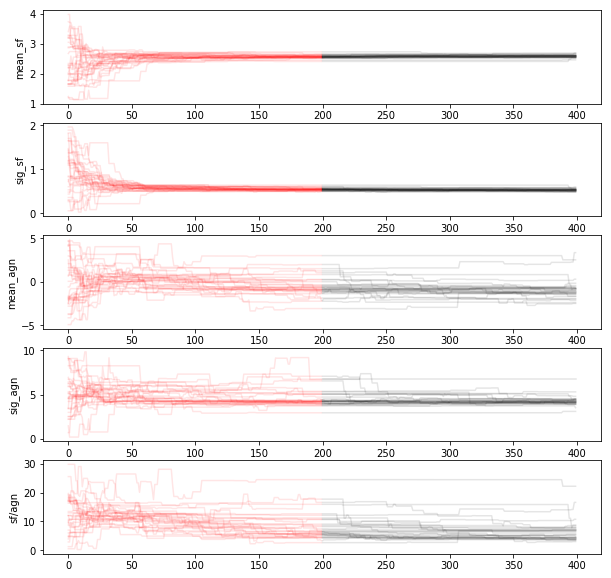

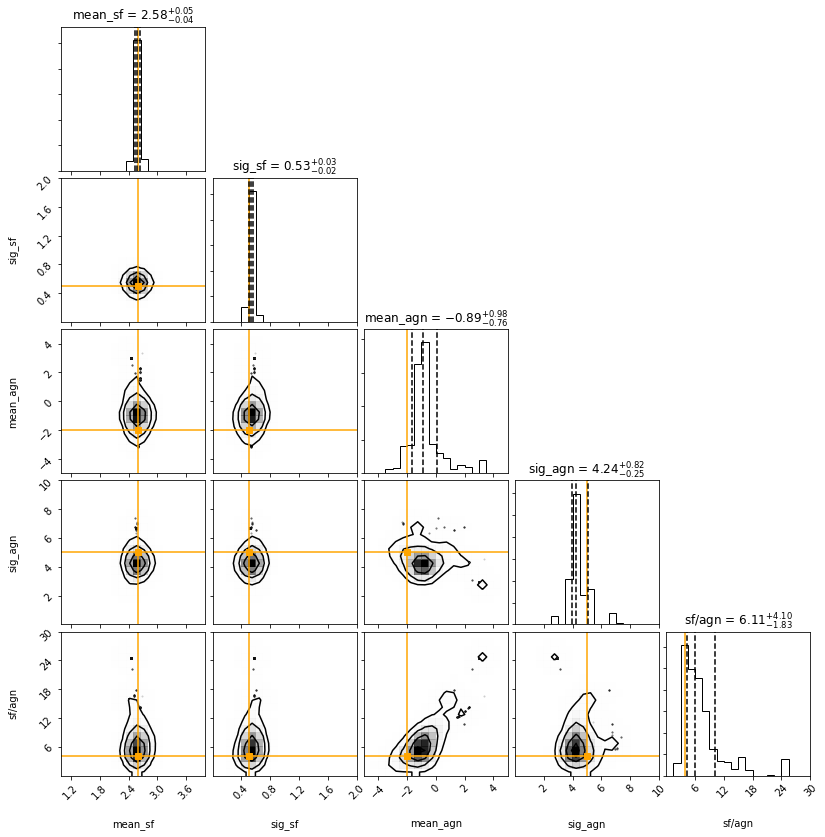

In [180]:
theta_true = np.array([q_sf_mean,q_sf_sig,q_agn_mean,q_agn_sig,n_sf/n_agn])

fig2,axarr = plt.subplots( ndim,1 ,figsize=(10,10))

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot( np.arange(0, preburns ,1) , sampler.chain[i,:preburns,j] , alpha=0.1, color='r' )
        axarr[j].plot( np.arange(preburns, burns+preburns ,1) , sampler.chain[i,preburns:,j] , alpha=0.1, color='k' )

    axarr[j].set_ylabel( params[j] )

import corner
fig = corner.corner(samples, labels= params , truths = theta_true, truth_color='orange', show_titles=True,\
        quantiles=[.16,.50,.84], smooth=1.0, \
        range = [(PRIORS[i][0],PRIORS[i][1]) for i in params])

In [90]:
median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]
error_params =   [(np.percentile(samples[:,i],84) - np.percentile(samples[:,i],16)) for i in range(ndim)]

for i in range(len(median_params)):
    print('{} is {} +/- {}'.format(params[i],median_params[i],error_params[i]))


#median_params

mean_sf is 2.6116703708371394 +/- 0.01907553222335423
sig_sf is 0.510352836343436 +/- 0.01587299396412989
mean_agn is -0.5335308229217521 +/- 1.7609625843190488
sig_agn is 5.471996790611662 +/- 1.2757370125165632
sf/agn is 18.62205974007829 +/- 6.534195087463374


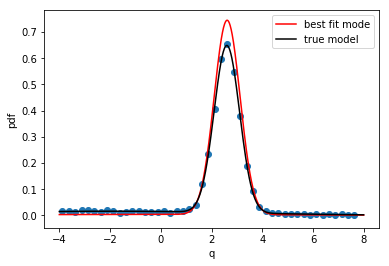

In [160]:
x = np.arange(-4,8,0.01)
y = model(x,median_params)
plt.plot(x,y,c='red',label='best fit mode')

y = model(x,[q_sf_mean,q_sf_sig,q_agn_mean,q_agn_sig,n_sf/n_agn])
plt.plot(x,y,c='black',label='true model')

x = np.arange(-4,8,0.25)
x_obs = get_center(x)
y_obs,_ = np.histogram(combined_q,bins=x)
y_obs = y_obs/(n_sf+n_agn)*4
plt.scatter(x_obs,y_obs)

plt.xlabel('q')
plt.ylabel('pdf')
plt.legend()
plt.show()

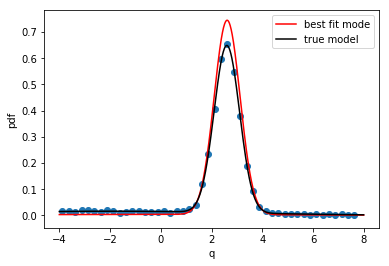

In [167]:
x = np.arange(-4,8,0.01)
y = model(x,median_params)
plt.plot(x,y,c='red',label='best fit mode')

y = model(x,[q_sf_mean,q_sf_sig,q_agn_mean,q_agn_sig,n_sf/n_agn])
plt.plot(x,y,c='black',label='true model')

x = np.arange(-4,8,0.25)
x_obs = get_center(x)
y_obs,_ = np.histogram(combined_q,bins=x)
y_obs = y_obs/(n_sf+n_agn)*4
plt.scatter(x_obs,y_obs)

plt.xlabel('q')
plt.ylabel('pdf')
plt.legend()
plt.show()